t-test，用于比较来自两个总体的样本【均值】的差异。但我们想比较两组以上呢？也许可以两两之间进行多次t-test，但这会增加发生假阳的风险。
在此，介绍方差分析ANOVA，可以同时比较多个group之间的【均值】差异。group的意思是总体或者 自变量的不同水平，比如下文中一个分类变量race可以分为5组

注意：ANOVA 讨论的对象是  【均值】差异；

     One-Sample t-test 【均值】差异；
     
     Two-Sample t-test 【均值】差异；
     
     pair t-test       【不涉及均值】；
     
* scipy.stats.f_oneway()         
* statsmodels.stats.multicomp.pairwise_tukeyhsd()   事后检验 

# One-Way ANOVA

one-way ANOVA 用于比较2个以上group【均值】的差异，只适用于数值数据。它本质回答的是：是否任一个group的均值不同于另一个。这里我们不详细讲计算过程，因为比t-test涉及更多计算，但过程是类似的：
1. 计算出检验统计量
2. 基于某种分布，比较检验统计量与临界值或者p-value法
3. 在ANOVA中，我们使用F-distribution

scipy.stats.f_oneway()可以实现该检验

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#例：对选民年龄和人口统计资料，使用ANOVA比较不同group的平均年龄
# H0：多个group的年龄均值不显著不同
# Ha: 多个group的年龄均值显著不同
#构造数据集

np.random.seed(12)

races =   ["asian","black","hispanic","other","white"]

# Generate random data
voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

# 年龄数据集：
voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
gb = voter_frame.groupby("race")
groups = gb.groups       # .groupby()之后有groups方法：转化成字典dict {group name -> group labels} 

# Etract individual groups
asian = voter_age[groups["asian"]]  # 得到每个年龄列
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

# Perform the ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=1.7744689357329695, pvalue=0.13173183201930463)

F-statistic: 1.774 

p-value: 0.1317 > 0.05 不拒绝H0。there is no significant difference between **【the means of each group】**.即各组年龄来自同一（泊松）分布。

### Now let's make new age data where the group means do differ and run a second ANOVA:

In [10]:
np.random.seed(12)

# Generate random data
voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

# Use a different distribution for white ages
white_ages = stats.poisson.rvs(loc=18, 
                              mu=32,
                              size=1000)
                                            #white_ages 和 voter_age 来自不同分布
voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

voter_age = np.where(voter_race=="white", white_ages, voter_age) 

# Group age data by race
voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups   

# Extract individual groups
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

#Perform the ANOVA
stats.f_oneway(asian,black,hispanic,other,white)

F_onewayResult(statistic=10.164699828386366, pvalue=4.5613242113994585e-08)

p << 1% ,拒绝H0。所以各组样本均值显著不同

## 事后检验“post-hoc test"
这里自定义了white_ages作为差异变量，但在实际中，【ANOVA检验出了显著不同，即各group是独立样本】（后面用.ttest_ind()的前提），但并不知道具体是哪个group(s)导致。为此，我们进行事后检验“post-hoc test".

一个方法是： 对所有groups 两两进行t-test

stats.ttest_ind()

In [27]:
# Get all race pairs
race_pairs = []
import itertools     
race_pairs=list(itertools.combinations(races,2)) # 组合

# Conduct t-test on each pair
for race1, race2 in race_pairs: 
    print(race1, race2)
    print(stats.ttest_ind(voter_age[groups[race1]], 
                          voter_age[groups[race2]])) 

asian black
Ttest_indResult(statistic=0.83864469097479799, pvalue=0.4027281369339345)
asian hispanic
Ttest_indResult(statistic=-0.42594691924932293, pvalue=0.67046690042407264)
asian other
Ttest_indResult(statistic=0.97952847396359999, pvalue=0.32988775000951509)
asian white
Ttest_indResult(statistic=-2.3181088112522881, pvalue=0.020804701566400217)
black hispanic
Ttest_indResult(statistic=-1.9527839210712925, pvalue=0.051561971719525937)
black other
Ttest_indResult(statistic=0.28025754367057176, pvalue=0.77957701111176592)
black white
Ttest_indResult(statistic=-5.3793038812818352, pvalue=1.039421216662395e-07)
hispanic other
Ttest_indResult(statistic=1.5853626170340225, pvalue=0.11396630528484335)
hispanic white
Ttest_indResult(statistic=-3.5160312714115376, pvalue=0.00046412986490666839)
other white
Ttest_indResult(statistic=-3.7638093220778721, pvalue=0.00018490576317593065)


The p-values for each pairwise t-test suggest mean of **white voters** is likely different from the other groups, since the p-values for each t-test involving the white group is** below 0.05**. 
![combination](combination.png)

### Bonferroni correction.

使用 未经校正的 pairwise t-test 可能会高估显著性，因为比较次数越多，坏事即使发生概率很小，次数多了也越容易碰上。为此，可以对多重比较问题进行校正。

校正方式是：显著性水平 / 比较的数量。比如本例中α=0.05，那么用于每一假设的显著水平为 0.05/10，即每一comparison，我们就想要 p-value ≤ 0.05/10 =0.005 来拒绝H0.

      ——This simple adjustment for multiple comparisons is known as the Bonferroni correction.
      
### Bonferroni法的适用性：
当比较次数不多时,Bonferroni法的效果较好.

但当比较次数较多(例如在10次以上)时,由于其检验水平选择得过低,结论偏于保守——稍大一点点的p-value，就能接受H0,而实际上是显著不同的.

### Tukey's test.
因此，有另一个常用的post-hoc test: Tukey's test

__pairwise_tukeyhsd()__:

group1,group2,meandiff,lower,upper,reject
asian,black,-0.8032,-3.4423,1.836,False
asian,hispanic,0.4143,-2.1011,2.9297,False
asian,other,-1.0645,-4.2391,2.11,False
asian,white,1.9547,-0.4575,4.3668,False
black,hispanic,1.2175,-0.386,2.821,False
black,other,-0.2614,-2.7757,2.253,False
black,white,2.7579,1.3217,4.194,True
hispanic,other,-1.4789,-3.863,0.9053,False
hispanic,white,1.5404,0.3468,2.734,True
other,white,3.0192,0.7443,5.2941,True


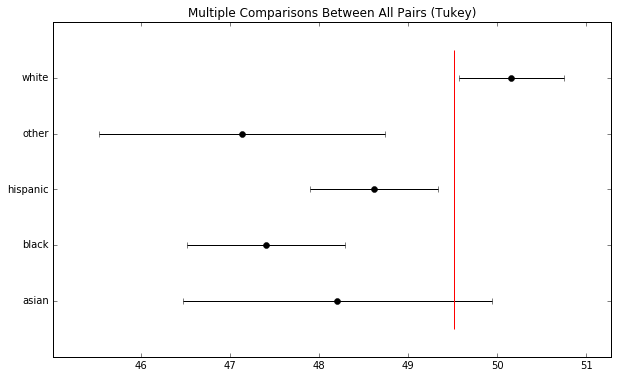

In [28]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=voter_age,    #Data         response variable    行和列需要分别指定，不能用pandas一次传入df
                          groups=voter_race,  #Groups      can be string or integers   
                          alpha=0.05)         #Significance level

tukey.plot_simultaneous()      # Plot group confidene intervals
plt.vlines(x=49.51, ymin=-0.5, ymax=4.5, color='red')

tukey.summary()              # See test summary

表中可以看出：

* 有3组Reject H0，每组都涉及‘white’，这表明‘white’可能与其他组都不同；

95%置信区间图也显示：

* 只有一组置信区间与‘white’的 重叠

# Wrap up

方差分析 ANOVA test 用于检验 【一个数值型因变量】 是否会根据 【一个分类型变量的不同水平】 而变异。

Scipy 可以帮助实现ANOVA，避免陷入复杂的计算过程。

若存在显著不同，可用 post-hoc test 来找出具体哪个group(s) 不同，常用方法有 Tukey's test——pairwise_tukeyhsd()